Import libraries

In [1]:
# === General Setup ===
import os
import gc
import random
import math
import time
import warnings
warnings.filterwarnings("ignore")

# === Data Handling ===
import numpy as np
import pandas as pd

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns

# === Machine Learning / Baselines ===
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import lightgbm as lgb  # for baseline boosting model

# === Deep Learning (PyTorch) ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# === Reproducibility ===
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# === Check GPU ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


Data cleaning and fetching

In [2]:
# === Mount Google Drive ===
from google.colab import drive
drive.mount('/content/drive')

# === Set file path ===
data_path = '/content/drive/MyDrive/Goquant/ETH.csv'

# === Load ETH.csv ===
import pandas as pd

df = pd.read_csv(data_path)

# === Display basic info ===
print("✅ File loaded successfully.\n")
print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nData Types:\n", df.dtypes)
print("\nMemory Usage:")
print(df.info(memory_usage='deep'))

# === Preview first few rows ===
df.head()


Mounted at /content/drive
✅ File loaded successfully.

Shape: (631292, 23)

Columns:
 ['timestamp', 'mid_price', 'bid_price1', 'bid_volume1', 'bid_price2', 'bid_volume2', 'bid_price3', 'bid_volume3', 'bid_price4', 'bid_volume4', 'bid_price5', 'bid_volume5', 'ask_price1', 'ask_volume1', 'ask_price2', 'ask_volume2', 'ask_price3', 'ask_volume3', 'ask_price4', 'ask_volume4', 'ask_price5', 'ask_volume5', 'label']

Data Types:
 timestamp       object
mid_price      float64
bid_price1     float64
bid_volume1    float64
bid_price2     float64
bid_volume2    float64
bid_price3     float64
bid_volume3    float64
bid_price4     float64
bid_volume4    float64
bid_price5     float64
bid_volume5    float64
ask_price1     float64
ask_volume1    float64
ask_price2     float64
ask_volume2    float64
ask_price3     float64
ask_volume3    float64
ask_price4     float64
ask_volume4    float64
ask_price5     float64
ask_volume5    float64
label          float64
dtype: object

Memory Usage:
<class 'pandas.c

,timestamp,mid_price,bid_price1,bid_volume1,bid_price2,bid_volume2,bid_price3,bid_volume3,bid_price4,bid_volume4,...,ask_volume1,ask_price2,ask_volume2,ask_price3,ask_volume3,ask_price4,ask_volume4,ask_price5,ask_volume5,label
0,2024-09-25 18:13:28,2581.605,2581.60,2980.3,2581.59,44.8,2581.56,139.1,2581.54,86.3,...,339.0,2581.67,9.2,2581.69,0.2,2581.70,23.4,2581.71,1.2,0.000060
1,2024-09-25 18:13:29,2581.285,2581.28,1400.6,2581.22,7.8,2581.19,5.0,2581.18,67.1,...,807.2,2581.30,144.4,2581.31,32.0,2581.32,151.0,2581.33,67.1,0.000057
2,2024-09-25 18:13:30,2581.285,2581.28,875.2,2581.22,7.8,2581.20,64.2,2581.19,5.0,...,807.5,2581.30,144.4,2581.31,32.0,2581.32,151.0,2581.33,52.0,0.000080
3,2024-09-25 18:13:31,2581.105,2581.10,1980.0,2581.09,508.4,2581.08,0.2,2581.05,18.7,...,833.3,2581.15,171.1,2581.20,60.7,2581.29,123.5,2581.30,104.0,0.000087
4,2024-09-25 18:13:32,2581.105,2581.10,1995.5,2581.09,508.4,2581.08,0.2,2581.05,18.7,...,717.3,2581.15,132.0,2581.20,60.7,2581.29,69.2,2581.30,242.9,0.000090


Timestamp check

In [3]:
# === Step 2.2: Timestamp Sanity Checks ===

# 1. Convert to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)

# 2. Check if timestamps are sorted
is_sorted = df['timestamp'].is_monotonic_increasing
print("✅ Timestamps sorted chronologically?" , is_sorted)

# 3. Check for duplicate timestamps
duplicate_count = df['timestamp'].duplicated().sum()
print("🔁 Duplicate timestamps found:", duplicate_count)

# 4. Check for missing seconds
expected_range = pd.date_range(start=df['timestamp'].min(), end=df['timestamp'].max(), freq='1S')
missing_timestamps = expected_range.difference(df['timestamp'])
print("⏳ Missing timestamps (1-second gaps):", len(missing_timestamps))

# 5. Log time range
print("\n🕒 Time Range Summary:")
print("Start:", df['timestamp'].min())
print("End  :", df['timestamp'].max())
print("Expected Rows:", len(expected_range))
print("Actual Rows  :", len(df))


✅ Timestamps sorted chronologically? True
🔁 Duplicate timestamps found: 0
⏳ Missing timestamps (1-second gaps): 0

🕒 Time Range Summary:
Start: 2024-09-25 18:13:28+00:00
End  : 2024-10-03 01:34:59+00:00
Expected Rows: 631292
Actual Rows  : 631292


Orderbook validity check

In [4]:
# === Step 2.3: Order Book Ladder Validity ===

# 1. Check bid price order: bid_price1 ≥ bid_price2 ≥ ... ≥ bid_price5
bid_price_cols = ['bid_price1', 'bid_price2', 'bid_price3', 'bid_price4', 'bid_price5']
bid_order_violations = (df[bid_price_cols].diff(axis=1).iloc[:, 1:] > 0).any(axis=1)
print("🔻 Bid price order violations:", bid_order_violations.sum())

# 2. Check ask price order: ask_price1 ≤ ask_price2 ≤ ... ≤ ask_price5
ask_price_cols = ['ask_price1', 'ask_price2', 'ask_price3', 'ask_price4', 'ask_price5']
ask_order_violations = (df[ask_price_cols].diff(axis=1).iloc[:, 1:] < 0).any(axis=1)
print("🔺 Ask price order violations:", ask_order_violations.sum())

# 3. Check locked and crossed books
locked_books = (df['ask_price1'] == df['bid_price1'])
crossed_books = (df['ask_price1'] < df['bid_price1'])
print("🔒 Locked book rows:", locked_books.sum())
print("❌ Crossed book rows:", crossed_books.sum())

# 4. Check for negative volumes
volume_cols = [col for col in df.columns if 'volume' in col]
negative_volumes = (df[volume_cols] < 0).any(axis=1)
print("🚫 Rows with negative volume:", negative_volumes.sum())

# (Optional) Count rows with 0 at best bid/ask volumes
zero_best_vol = ((df['bid_volume1'] == 0) | (df['ask_volume1'] == 0))
print("⚠️ Rows with zero volume at best bid/ask:", zero_best_vol.sum())


🔻 Bid price order violations: 1
🔺 Ask price order violations: 1
🔒 Locked book rows: 0
❌ Crossed book rows: 0
🚫 Rows with negative volume: 1
⚠️ Rows with zero volume at best bid/ask: 0


Mid price and spread checks

In [5]:
# === Step 2.4: Mid-Price and Spread Consistency Checks ===

# 1. Compute expected mid-price
df['mid_expected'] = (df['bid_price1'] + df['ask_price1']) / 2

# 2. Calculate absolute and relative error from reported mid_price
df['mid_abs_error'] = np.abs(df['mid_price'] - df['mid_expected'])
df['mid_rel_error'] = df['mid_abs_error'] / df['mid_expected']

# 3. Define mid-price error threshold (tick size ~ $0.01 or $0.02)
mid_error_threshold = 0.02
mid_error_violations = df['mid_abs_error'] > mid_error_threshold
print(f"🧮 Mid-price deviation > {mid_error_threshold}: {mid_error_violations.sum()} rows")

# 4. Compute spread and relative spread
df['spread'] = df['ask_price1'] - df['bid_price1']
df['rel_spread'] = df['spread'] / df['mid_expected']

# 5. Describe spread stats
print("\n📊 Spread Summary Stats:")
print(df['spread'].describe())
print("\n📊 Relative Spread Summary Stats:")
print(df['rel_spread'].describe())

# 6. Identify extreme spreads (e.g., top 0.1% outliers)
spread_threshold = df['spread'].quantile(0.999)
extreme_spread_rows = df['spread'] > spread_threshold
print(f"🚨 Extreme spreads > {spread_threshold:.4f}: {extreme_spread_rows.sum()} rows")

# 7. Save key error columns for later filtering
cols_to_keep = ['timestamp', 'mid_price', 'mid_expected', 'mid_abs_error', 'spread', 'rel_spread']
df_check = df[cols_to_keep].copy()


🧮 Mid-price deviation > 0.02: 1 rows

📊 Spread Summary Stats:
count    5.958620e+05
mean     8.375769e+33
std      6.465432e+36
min      1.000000e-02
25%      1.000000e-02
50%      1.000000e-02
75%      1.000000e-02
max      4.990803e+39
Name: spread, dtype: float64

📊 Relative Spread Summary Stats:
count    595862.000000
mean          0.000007
std           0.002591
min           0.000004
25%           0.000004
50%           0.000004
75%           0.000004
max           2.000000
Name: rel_spread, dtype: float64
🚨 Extreme spreads > 0.0200: 515 rows


Depth and imbalance checks


📊 Imbalance Summary Stats:
count    595862.000000
mean         -0.000797
std           0.601713
min          -1.000000
25%          -0.528699
50%          -0.002169
75%           0.528057
max           0.999803
Name: imbalance, dtype: float64


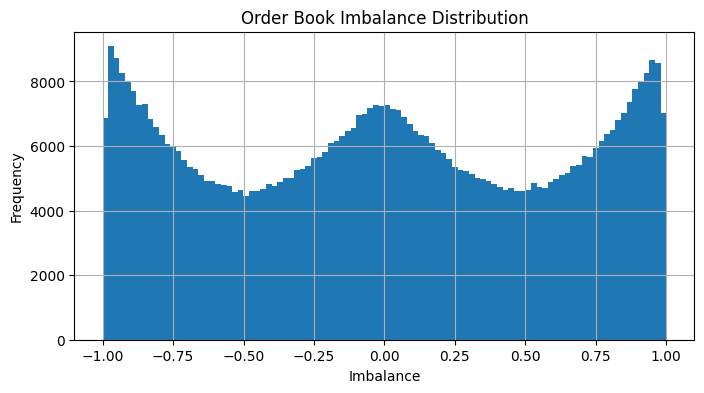


❗ Zero total depth (bid or ask): 35430
❗ Imbalance = ±1 (fully one-sided books): 1


In [6]:
# === Step 2.5: Depth and Imbalance Checks ===

# 1. Compute total depth on each side
df['bid_depth'] = df[[f'bid_volume{i}' for i in range(1, 6)]].sum(axis=1)
df['ask_depth'] = df[[f'ask_volume{i}' for i in range(1, 6)]].sum(axis=1)

# 2. Compute imbalance: (bid - ask) / (bid + ask)
df['imbalance'] = (df['bid_depth'] - df['ask_depth']) / (df['bid_depth'] + df['ask_depth'])

# 3. Basic stats on imbalance
print("\n📊 Imbalance Summary Stats:")
print(df['imbalance'].describe())

# 4. Plot imbalance distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
df['imbalance'].hist(bins=100)
plt.title("Order Book Imbalance Distribution")
plt.xlabel("Imbalance")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# 5. Detect anomalies
zero_depth_rows = ((df['bid_depth'] == 0) | (df['ask_depth'] == 0))
extreme_imbalance_rows = df['imbalance'].abs() == 1

print("\n❗ Zero total depth (bid or ask):", zero_depth_rows.sum())
print("❗ Imbalance = ±1 (fully one-sided books):", extreme_imbalance_rows.sum())


Microstructure Activity analysis

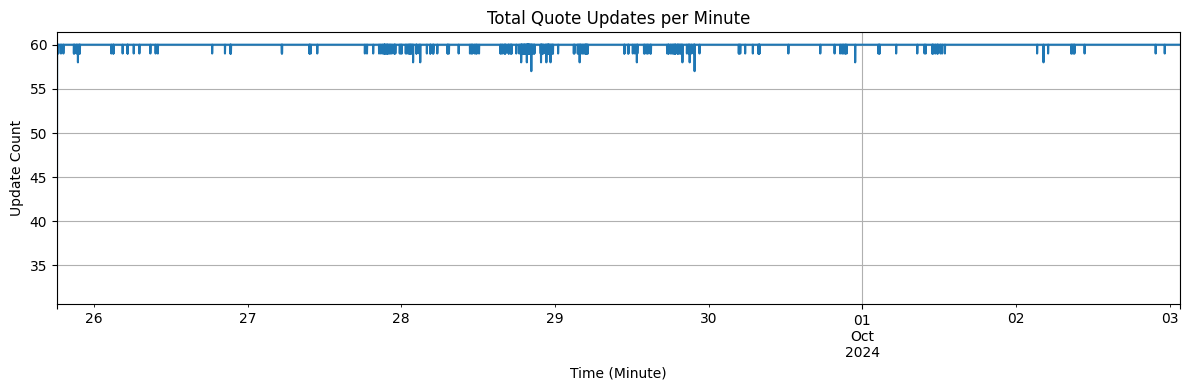


📊 Quote Update Summary:
Total rows: 631292
Rows with price update: 259243
Rows with volume-only update: 371759


In [7]:
# === Step 2.6: Microstructure Activity Analysis ===

# 1. Identify price changes at top of book
df['bid_price1_change'] = df['bid_price1'].diff() != 0
df['ask_price1_change'] = df['ask_price1'].diff() != 0
df['price_update'] = df['bid_price1_change'] | df['ask_price1_change']

# 2. Identify volume-only changes (price same but volume changed)
df['bid_volume1_change'] = df['bid_volume1'].diff() != 0
df['ask_volume1_change'] = df['ask_volume1'].diff() != 0
df['volume_only_update'] = ~df['price_update'] & (df['bid_volume1_change'] | df['ask_volume1_change'])

# 3. Group by minute and count updates
df['minute'] = df['timestamp'].dt.floor('min')
activity_per_min = df.groupby('minute').agg({
    'price_update': 'sum',
    'volume_only_update': 'sum'
}).rename(columns={
    'price_update': 'price_updates_per_min',
    'volume_only_update': 'volume_only_updates_per_min'
})
activity_per_min['total_updates'] = activity_per_min.sum(axis=1)

# 4. Plot total update rate over time
plt.figure(figsize=(12,4))
activity_per_min['total_updates'].plot()
plt.title("Total Quote Updates per Minute")
plt.xlabel("Time (Minute)")
plt.ylabel("Update Count")
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Summary
print("\n📊 Quote Update Summary:")
print("Total rows:", len(df))
print("Rows with price update:", df['price_update'].sum())
print("Rows with volume-only update:", df['volume_only_update'].sum())


Return and volatility analysis

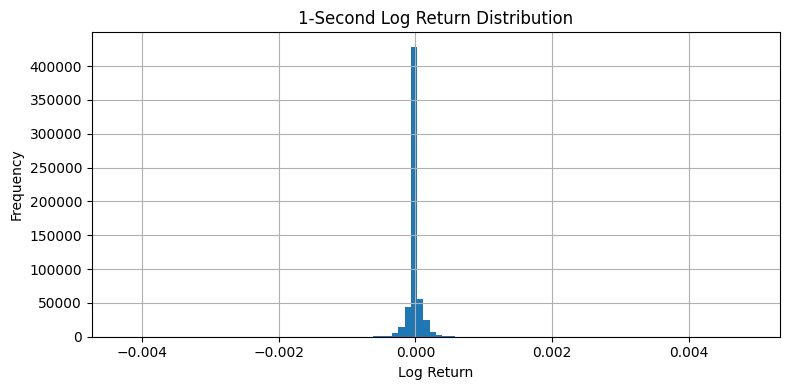

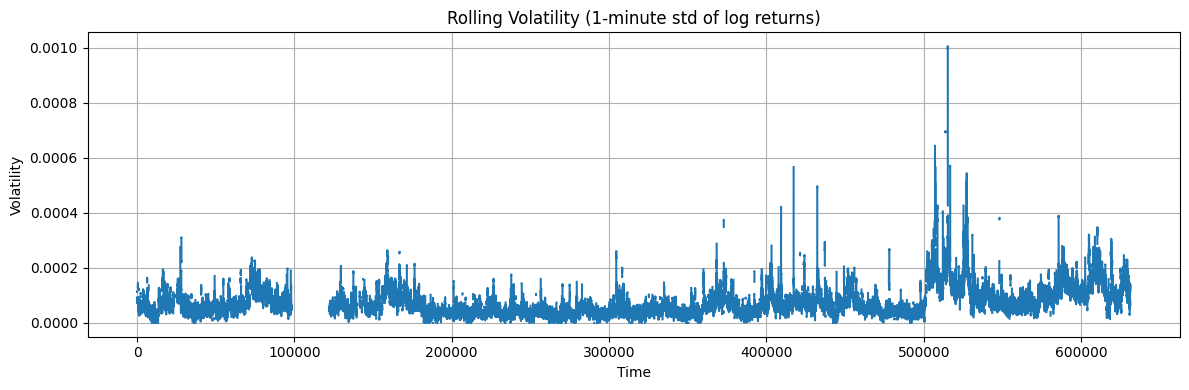

In [8]:
import numpy as np

# 1. Ensure timestamp is datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# 2. Sort (safety check)
df = df.sort_values('timestamp')

# 3. Calculate log returns using mid_price
df['log_return'] = np.log(df['mid_price']) - np.log(df['mid_price'].shift(1))

# 4. Plot return histogram
plt.figure(figsize=(8,4))
df['log_return'].dropna().hist(bins=100)
plt.title("1-Second Log Return Distribution")
plt.xlabel("Log Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Calculate rolling volatility (1-minute window = 60s)
df['rolling_volatility'] = df['log_return'].rolling(window=60).std()

# 6. Plot rolling volatility
plt.figure(figsize=(12,4))
df['rolling_volatility'].plot()
plt.title("Rolling Volatility (1-minute std of log returns)")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.grid(True)
plt.tight_layout()
plt.show()


Train test split

In [9]:
import pandas as pd

# Define paths
train_path = "/content/drive/MyDrive/Goquant/ETH.csv"
test_path = "/content/drive/MyDrive/Goquant/ETH (1).csv"

# Load both files
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Print confirmation
print("✅ Files loaded successfully!\n")

print("📘 Training File: ETH.csv")
print(f"➡ Shape: {df_train.shape}\n")

print("📗 Test File: ETH (1).csv")
print(f"➡ Shape: {df_test.shape}")


✅ Files loaded successfully!

📘 Training File: ETH.csv
➡ Shape: (631292, 23)

📗 Test File: ETH (1).csv
➡ Shape: (270548, 22)


Label checks and feature normalisation

In [10]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Step 3.2 — Check for proper label alignment
print("\n🔍 Verifying label alignment with mid_price shift...")

df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])

# Check time difference between rows
row_time_diffs = df_train['timestamp'].diff().value_counts()
print("🕒 Unique time gaps between rows (expected: 1s):")
print(row_time_diffs.head())

# Inspect if label corresponds to mid_price 10 seconds ahead
# We'll shift mid_price by -10 steps (10s forward)
df_train['mid_price_t+10'] = df_train['mid_price'].shift(-10)
df_train['label_diff'] = np.abs(df_train['mid_price_t+10'] - df_train['label'])

print("\n📏 Label vs. mid_price_t+10 diff stats:")
print(df_train['label_diff'].describe())

# Optional: Display a few sample rows to verify visually
print("\n🔍 Sample rows with label vs mid_price_t+10:")
print(df_train[['mid_price', 'mid_price_t+10', 'label', 'label_diff']].head(15))

# Step 3.3 — Drop rows with NaNs
print("\n🧹 Dropping rows with any missing values...")
before_drop = df_train.shape[0]
df_train.dropna(inplace=True)
after_drop = df_train.shape[0]
print(f"✅ Dropped {before_drop - after_drop} rows (remaining: {after_drop})")

# Step 3.4 — Normalize features for GRU/LSTM
print("\n⚙️ Standardizing features...")

# Define feature columns (excluding timestamp, label, and any engineered columns)
feature_cols = [col for col in df_train.columns
                if col not in ['timestamp', 'label', 'mid_price_t+10', 'label_diff']]

scaler = StandardScaler()
df_train[feature_cols] = scaler.fit_transform(df_train[feature_cols])

print("✅ Features normalized successfully.")



🔍 Verifying label alignment with mid_price shift...
🕒 Unique time gaps between rows (expected: 1s):
timestamp
0 days 00:00:01    631291
Name: count, dtype: int64

📏 Label vs. mid_price_t+10 diff stats:
count    5.957410e+05
mean     4.188735e+33
std      3.233044e+36
min      2.352225e+03
25%      2.582815e+03
50%      2.635145e+03
75%      2.664755e+03
max      2.495401e+39
Name: label_diff, dtype: float64

🔍 Sample rows with label vs mid_price_t+10:
    mid_price  mid_price_t+10     label   label_diff
0    2581.605        2581.455  0.000060  2581.454940
1    2581.285        2582.045  0.000057  2582.044943
2    2581.285        2581.835  0.000080  2581.834920
3    2581.105        2581.605  0.000087  2581.604913
4    2581.105        2581.505  0.000090  2581.504910
5    2581.275        2581.505  0.000091  2581.504909
6    2581.275        2581.505  0.000090  2581.504910
7    2581.455        2581.455  0.000090  2581.454910
8    2581.455        2581.445  0.000087  2581.444913
9    2581.455

Evaluation metric functions

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(y_true, y_pred):
    """
    Computes key regression evaluation metrics.
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)

    # Optional: Directional accuracy
    direction_true = np.sign(np.diff(y_true))
    direction_pred = np.sign(np.diff(y_pred))
    directional_accuracy = np.mean(direction_true == direction_pred) * 100

    print(f"📊 Evaluation Metrics:")
    print(f"🔹 MSE  : {mse:.6f}")
    print(f"🔹 RMSE : {rmse:.6f}")
    print(f"🔹 MAE  : {mae:.6f}")
    print(f"🔹 Directional Accuracy: {directional_accuracy:.2f}%")

    return {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "directional_accuracy": directional_accuracy
    }


Feature engineering - helper functions

In [12]:
import numpy as np
import pandas as pd

#Utility helpers

def _safe_div(a, b):
    """Elementwise safe division."""
    return np.where(b != 0, a / b, 0.0)

def _log_return(x, lag=1):
    """Compute log return with lag (NumPy arrays only)."""
    x = np.asarray(x, dtype=float)
    prev = np.roll(x, lag)
    out = np.zeros_like(x, dtype=float)
    mask = (prev > 0) & (x > 0)
    out[mask] = np.log(x[mask]) - np.log(prev[mask])
    out[~mask] = 0.0
    out[:lag] = 0.0
    return out

def _rolling_count_events(series, window):
    """Count boolean events in the past window using cumulative sum trick."""
    s = series.astype(int)
    c = s.cumsum()
    out = c - c.shift(window, fill_value=0)
    return out

def _add_time_cyclical(df, ts_col="timestamp"):
    """Add second-of-day sine cos and weekday features to DataFrame."""
    dt = pd.to_datetime(df[ts_col])
    sod = dt.dt.hour * 3600 + dt.dt.minute * 60 + dt.dt.second
    w = dt.dt.weekday
    df["sod_sin"] = np.sin(2 * np.pi * sod / 86400.0)
    df["sod_cos"] = np.cos(2 * np.pi * sod / 86400.0)
    df["weekday"] = w.astype(int)
    return df

#Core feature builders

def add_top_of_book_features(df):
    """Adds core top-of-book price and volume features."""

    # Parse and cast required columns
    bid = df["bid_price1"].astype(float)
    ask = df["ask_price1"].astype(float)
    bvol = df["bid_volume1"].astype(float)
    avol = df["ask_volume1"].astype(float)

    # Mid-price and spread
    df["mid"] = (bid + ask) * 0.5
    df["spread"] = ask - bid
    df["rel_spread_bp"] = _safe_div(df["spread"], df["mid"]) * 1e4  # basis points

    # Microprice = size-weighted mid
    denom = bvol + avol
    df["microprice"] = _safe_div(ask * bvol + bid * avol, denom)

    # Log returns (lags)
    for lag in [1, 2, 3, 5, 10, 30, 60]:
        df[f"ret_mid_lag{lag}"] = _log_return(df["mid"].values, lag=lag)
        df[f"ret_micro_lag{lag}"] = _log_return(df["microprice"].values, lag=lag)

    # Binary flags for quote updates
    df["chg_bid_px1"] = (bid.diff().fillna(0) != 0).astype(int)
    df["chg_ask_px1"] = (ask.diff().fillna(0) != 0).astype(int)

    # Rolling count of quote updates
    for w in [10, 30, 60, 120, 300]:
        df[f"cnt_bid_px1_chg_{w}s"] = _rolling_count_events(df["chg_bid_px1"], w)
        df[f"cnt_ask_px1_chg_{w}s"] = _rolling_count_events(df["chg_ask_px1"], w)

    return df

def add_depth_and_imbalance_features(df, levels=5):
    """Adds market depth features and volume/price imbalance features."""

    # Construct column lists
    bid_vol_cols = [f"bid_volume{i}" for i in range(1, levels + 1)]
    ask_vol_cols = [f"ask_volume{i}" for i in range(1, levels + 1)]
    bid_px_cols = [f"bid_price{i}" for i in range(1, levels + 1)]
    ask_px_cols = [f"ask_price{i}" for i in range(1, levels + 1)]

    # Cast to float
    bv = df[bid_vol_cols].astype(float)
    av = df[ask_vol_cols].astype(float)

    # Total depth & imbalance
    df["depth_bid"] = bv.sum(axis=1)
    df["depth_ask"] = av.sum(axis=1)
    df["depth_total"] = df["depth_bid"] + df["depth_ask"]
    df["imbalance_lvl1"] = _safe_div(df["bid_volume1"] - df["ask_volume1"], df["bid_volume1"] + df["ask_volume1"])
    df["imbalance_total"] = _safe_div(df["depth_bid"] - df["depth_ask"], df["depth_total"])

    # Depth-weighted average prices (WAP)
    bp = df[bid_px_cols].astype(float).values
    ap = df[ask_px_cols].astype(float).values
    bv_np = bv.values
    av_np = av.values

    bid_wap = _safe_div((bp * bv_np).sum(axis=1), bv_np.sum(axis=1))
    ask_wap = _safe_div((ap * av_np).sum(axis=1), av_np.sum(axis=1))

    df["bid_wap"] = bid_wap
    df["ask_wap"] = ask_wap
    df["wap_spread"] = ask_wap - bid_wap
    df["wap_mid"] = 0.5 * (ask_wap + bid_wap)

    return df

def add_volatility_proxies(df):
    """Adds realized variance, volatility, and bipower variation from mid-price returns."""

    r = pd.Series(_log_return(df["mid"].values, lag=1)).astype(float)
    r.name = "r1"

    # Realized variance and volatility
    for w in [10, 30, 60, 120, 300]:
        rv = r.pow(2).rolling(w).sum()
        df[f"rv_{w}s"] = rv.values
        df[f"rvol_{w}s"] = np.sqrt(np.maximum(rv.values, 0.0))

    # Bipower variation
    abs_r = r.abs()
    for w in [10, 30, 60, 120, 300]:
        bp = (abs_r.shift(1) * abs_r).rolling(w).sum() * (np.pi / 2.0)
        df[f"bpv_{w}s"] = bp.values

    return df

def add_order_flow_features(df):
    """Adds Order Flow Imbalance (OFI) and its rolling statistics."""

    bp = df["bid_price1"].astype(float).values
    ap = df["ask_price1"].astype(float).values
    bv = df["bid_volume1"].astype(float).values
    av = df["ask_volume1"].astype(float).values

    # Previous tick values
    bp_prev = np.roll(bp, 1); bp_prev[0] = bp[0]
    ap_prev = np.roll(ap, 1); ap_prev[0] = ap[0]
    bv_prev = np.roll(bv, 1); bv_prev[0] = bv[0]
    av_prev = np.roll(av, 1); av_prev[0] = av[0]

    # OFI computation
    ofi = np.zeros_like(bp, dtype=float)
    ofi += np.where(bp > bp_prev, bv, 0.0)
    ofi += np.where(bp < bp_prev, -bv_prev, 0.0)
    ofi += np.where(bp == bp_prev, bv - bv_prev, 0.0)
    ofi += np.where(ap < ap_prev, -av, 0.0)
    ofi += np.where(ap > ap_prev, av_prev, 0.0)
    ofi += np.where(ap == ap_prev, -(av - av_prev), 0.0)

    df["ofi_lvl1"] = ofi

    # Rolling stats
    for w in [10, 30, 60, 120, 300]:
        df[f"ofi_sum_{w}s"] = pd.Series(ofi).rolling(w).sum().values
        df[f"ofi_std_{w}s"] = pd.Series(ofi).rolling(w).std().fillna(0.0).values

    return df

def add_liquidity_flags(df):
    """Adds binary flags for wide spreads and shallow order book depth."""

    # Use expanding window to avoid lookahead bias
    spread_med = df["spread"].expanding().median()
    depth_q10 = df["depth_total"].expanding().quantile(0.10)

    df["flag_wide_spread"] = (df["spread"] > 3.0 * spread_med).astype(int)
    df["flag_shallow_depth"] = (df["depth_total"] < depth_q10).astype(int)

    return df

def add_cross_asset_features(eth_df, peer_df, peer_name="BTC"):
    """
    Merges peer asset data (e.g., BTC) and computes lagged returns and rolling correlation with ETH.
    """
    use_cols = ["timestamp", "mid"]
    peer = peer_df[use_cols].copy()
    peer.rename(columns={"mid": f"mid_{peer_name}"}, inplace=True)

    # Lagged returns for peer asset
    for lag in [1, 2, 3, 5, 10, 30, 60]:
        peer[f"ret_mid_{peer_name}_lag{lag}"] = _log_return(peer[f"mid_{peer_name}"].values, lag=lag)

    out = eth_df.merge(peer, on="timestamp", how="left")

    # Correlation between ETH and peer asset returns
    r_eth = pd.Series(_log_return(out["mid"].values, lag=1))
    r_peer = pd.Series(_log_return(out[f"mid_{peer_name}"].values, lag=1))

    for w in [60, 120, 300]:
        corr = r_eth.rolling(w).corr(r_peer)
        out[f"corr_eth_{peer_name}_{w}s"] = corr.values

    return out

def engineer_features_for_asset(df):
    """Applies the full feature engineering pipeline for one asset (e.g., ETH/NIFTY)."""
    df = df.copy()
    df.sort_values("timestamp", inplace=True)

    # Run all core feature functions
    _add_time_cyclical(df, "timestamp")
    add_top_of_book_features(df)
    add_depth_and_imbalance_features(df, levels=5)
    add_volatility_proxies(df)
    add_order_flow_features(df)
    add_liquidity_flags(df)

    # Prevent lookahead by shifting numeric features
    base_cols = set(df.columns)
    num_df = df.select_dtypes(include=[np.number])

    # Identify new numeric features
    new_cols = [c for c in num_df.columns if c not in base_cols or c in [
        "mid", "spread", "rel_spread_bp", "microprice",
        "depth_bid", "depth_ask", "depth_total",
        "imbalance_lvl1", "imbalance_total",
        "bid_wap", "ask_wap", "wap_spread", "wap_mid",
        "ofi_lvl1"
    ]]

    # Do not shift raw order book values
    raw_cols = [f"{side}_{typ}{i}" for i in range(1, 6) for side in ["bid", "ask"] for typ in ["price", "volume"]]
    shift_cols = [c for c in new_cols if c not in raw_cols]

    df[shift_cols] = df[shift_cols].shift(1)

    return df

def build_eth_with_peers(eth_df, peers_dict):
    """
    Run full ETH feature engineering and merge peer (e.g., BTC, VIX) features.
    peers_dict = {"BTC": btc_df, "VIX": vix_df, ...}
    """
    eth_feat = engineer_features_for_asset(eth_df)
    out = eth_feat

    for name, peer_df in peers_dict.items():
        peer_feat = engineer_features_for_asset(peer_df)[["timestamp", "mid"]].copy()
        out = add_cross_asset_features(out, peer_feat, peer_name=name)

    return out

def finalize_feature_table(df, label_col=None):
    """
    Final cleanup of feature table.
    - Drops rows with NaNs created by shift/rolling.
    - Retains the label column if specified.
    """
    keep_cols = [c for c in df.columns if c != label_col] + \
                ([label_col] if label_col and label_col in df.columns else [])

    df = df[keep_cols].copy()
    df = df.dropna().reset_index(drop=True)

    return df




In [13]:
import pandas as pd
import os

# Mount your Google Drive (if not done already)
from google.colab import drive
drive.mount('/content/drive')

# Define the correct paths inside your 'Goquant' folder
base_path = "/content/drive/MyDrive/Goquant"
eth_train_path = os.path.join(base_path, "ETH.csv")
eth_test_path = os.path.join(base_path, "ETH (1).csv")

# Load the CSVs
eth_train = pd.read_csv(eth_train_path)
eth_test = pd.read_csv(eth_test_path)

# Print basic schema info
print("🟢 ETH Train Info:")
print(eth_train.info(), "\n")

print("🟡 ETH Test Info:")
print(eth_test.info(), "\n")

# Check for column differences
print("📊 Columns in Train but not Test:", set(eth_train.columns) - set(eth_test.columns))
print("📊 Columns in Test but not Train:", set(eth_test.columns) - set(eth_train.columns))

# Check timestamp ranges
print("🕒 Train Timestamp Range:", eth_train['timestamp'].min(), "→", eth_train['timestamp'].max())
print("🕒 Test Timestamp Range:", eth_test['timestamp'].min(), "→", eth_test['timestamp'].max())

# Show a few sample rows
print("\n🔍 Sample Train Rows:")
print(eth_train.head(), "\n")
print("🔍 Sample Test Rows:")
print(eth_test.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🟢 ETH Train Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631292 entries, 0 to 631291
Data columns (total 23 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   timestamp    631292 non-null  object 
 1   mid_price    595862 non-null  float64
 2   bid_price1   595862 non-null  float64
 3   bid_volume1  595862 non-null  float64
 4   bid_price2   595862 non-null  float64
 5   bid_volume2  595862 non-null  float64
 6   bid_price3   595862 non-null  float64
 7   bid_volume3  595862 non-null  float64
 8   bid_price4   595862 non-null  float64
 9   bid_volume4  595862 non-null  float64
 10  bid_price5   595862 non-null  float64
 11  bid_volume5  595862 non-null  float64
 12  ask_price1   595862 non-null  float64
 13  ask_volume1  595862 non-null  float64
 14  ask_price2   595862 non-null  float64
 15  ask_vo

Feature scaling

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib

# === STEP 1: Load Train and Test ===
base_path = "/content/drive/MyDrive/Goquant"
eth_train = pd.read_csv(f"{base_path}/ETH.csv")
eth_test = pd.read_csv(f"{base_path}/ETH (1).csv")

# === STEP 2: Apply Feature Engineering ===
train_df = engineer_features_for_asset(eth_train)
test_df = engineer_features_for_asset(eth_test)

# === STEP 3: Finalize & Drop NaNs ===
train_df = finalize_feature_table(train_df, label_col="label")
test_df = finalize_feature_table(test_df)  # no label, so we don't specify it

# === STEP 4: Outlier Clipping (1st–99th percentile from train) ===
# Get numeric columns from train_df
numeric_cols = train_df.select_dtypes(include=[np.number]).columns

# Drop 'label' from numeric_cols for test_df if it's present
numeric_cols_without_label = numeric_cols.drop('label') if 'label' in numeric_cols else numeric_cols

# Compute 1st and 99th percentiles on train data
clip_bounds = train_df[numeric_cols].quantile([0.01, 0.99])

# Clip outliers on both train and test separately
train_df[numeric_cols] = train_df[numeric_cols].clip(lower=clip_bounds.loc[0.01], upper=clip_bounds.loc[0.99], axis=1)
test_df[numeric_cols_without_label] = test_df[numeric_cols_without_label].clip(
    lower=clip_bounds.loc[0.01, numeric_cols_without_label],
    upper=clip_bounds.loc[0.99, numeric_cols_without_label],
    axis=1
)


# === STEP 5: Standard Scaling ===
X_train = train_df.drop(columns=["timestamp", "label"])
y_train = train_df["label"]

X_test = test_df.drop(columns=["timestamp"])  # no label in test

# Fit scaler on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler for future use
joblib.dump(scaler, "/content/drive/MyDrive/Goquant/scaler.pkl")

# Optional: Convert back to DataFrame for exploration
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("✅ Step 5 complete.")
print("Train shape:", X_train_scaled.shape, "| Test shape:", X_test_scaled.shape)




✅ Step 5 complete.
Train shape: (585892, 91) | Test shape: (261239, 91)


In [15]:
from sklearn.preprocessing import StandardScaler

# Identify columns to scale: exclude 'timestamp' and 'label'
features_to_scale = [col for col in train_df.columns if col not in ['timestamp', 'label']]

# Initialize and fit scaler on train data
scaler = StandardScaler()
train_df[features_to_scale] = scaler.fit_transform(train_df[features_to_scale])

# Apply same scaling to test data
test_df[features_to_scale] = scaler.transform(test_df[features_to_scale])


Sequence Windowing

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# === CONFIGURATION ===
LOOKBACK = 180  # seconds
STRIDE = 1      # one second
FUTURE_OFFSET = 10  # predict IV at t+10s

# === Step 1: Drop rows without full history or future target ===
def create_sequences(df, lookback, offset, stride=1):
    """
    Create sliding window sequences and targets for a given dataframe.
    """
    features = df.drop(columns=["timestamp", "label"]).values
    targets = df["label"].values

    X = []
    y = []

    for i in range(0, len(df) - lookback - offset, stride):
        X_window = features[i : i + lookback]
        y_target = targets[i + lookback + offset - 1]  # target at t+10
        X.append(X_window)
        y.append(y_target)

    return np.array(X), np.array(y)

# === Step 2: Apply to both train and test ===
X_train, y_train = create_sequences(train_df, LOOKBACK, FUTURE_OFFSET)
X_test, y_test = create_sequences(test_df, LOOKBACK, FUTURE_OFFSET)

print(f"✅ X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"✅ X_test: {X_test.shape}, y_test: {y_test.shape}")

class LOBSequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = LOBSequenceDataset(X_train, y_train)
test_dataset = LOBSequenceDataset(X_test, y_test)

# Example dataloaders (batch_size = 64)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
